Training MC Dropout Model...
Training Standard Model...
Training Variational Inference Model...

Training PBP Ensemble...

=== Model Performance ===
MC Dropout  - RMSE: 3.1052, MAE: 2.0086, Coverage: 0.7941, NLL: 2.7976
VI BBB      - RMSE: 3.5466, MAE: 2.4709, Coverage: 0.0196, NLL: 2029.0377
PBP Style   - RMSE: 3.2691, MAE: 2.0773, Coverage: 0.2941, NLL: 52.9691


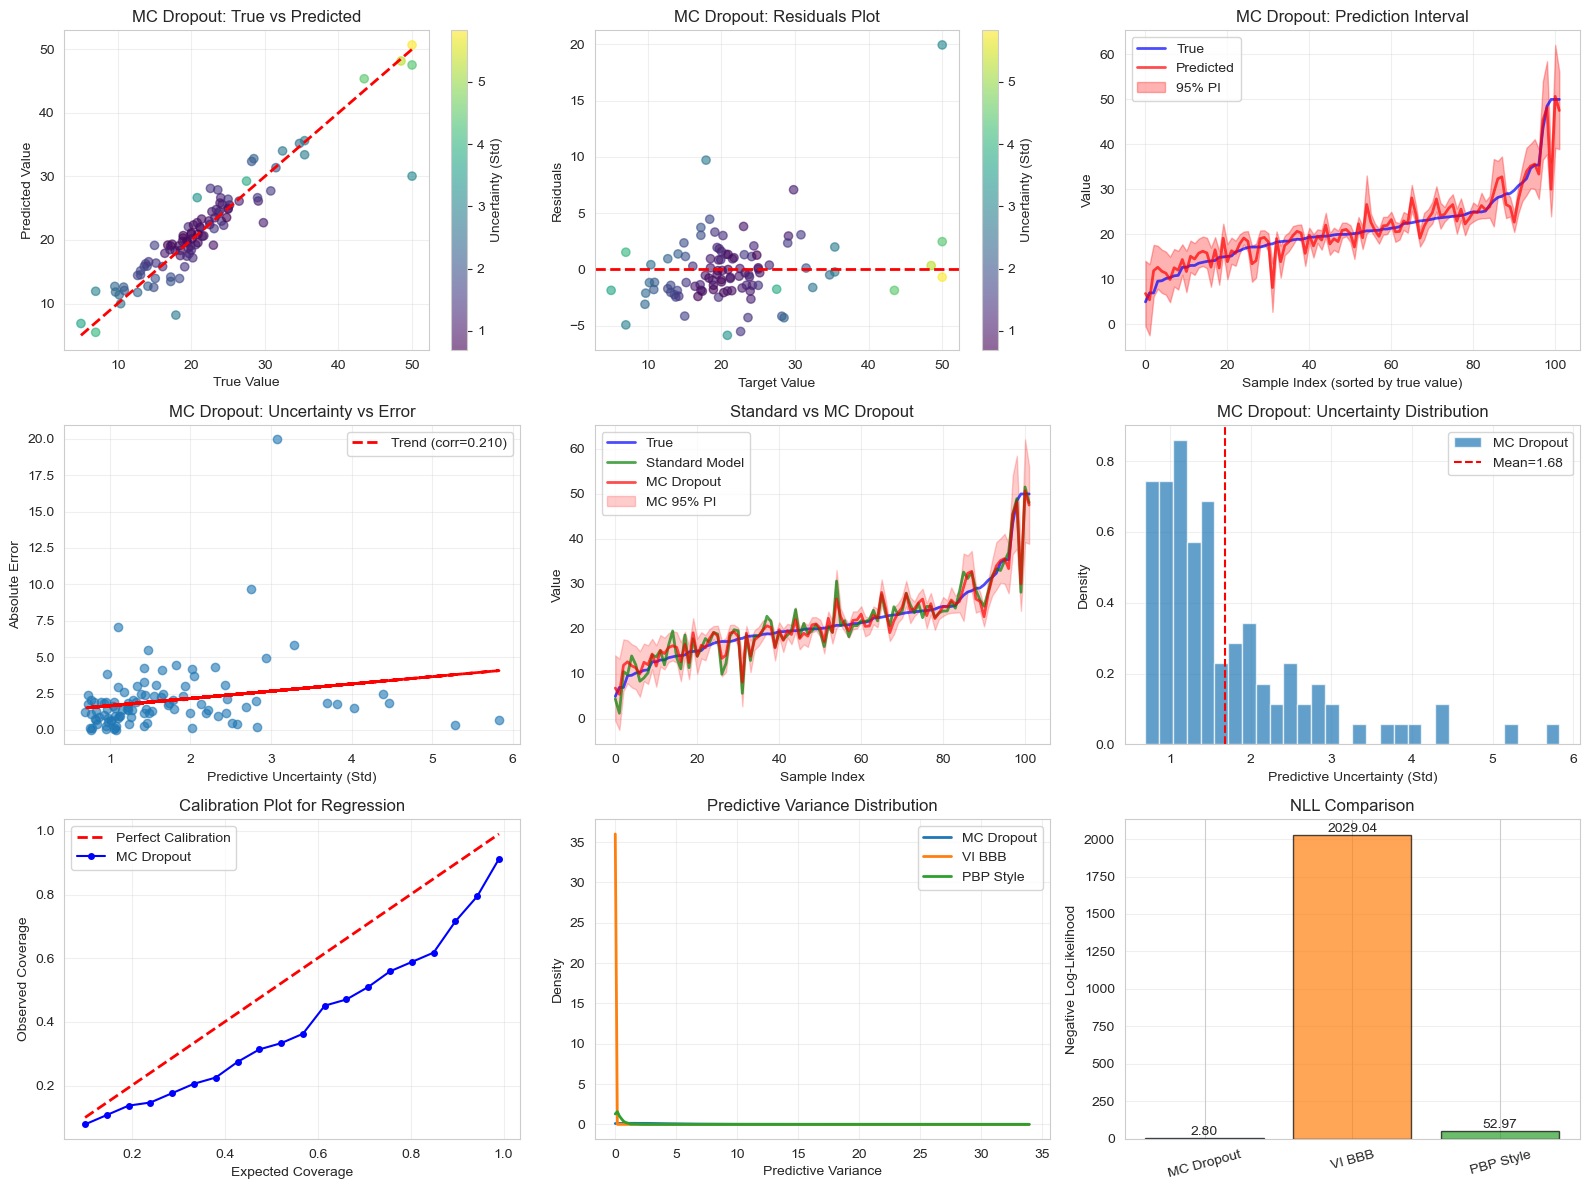

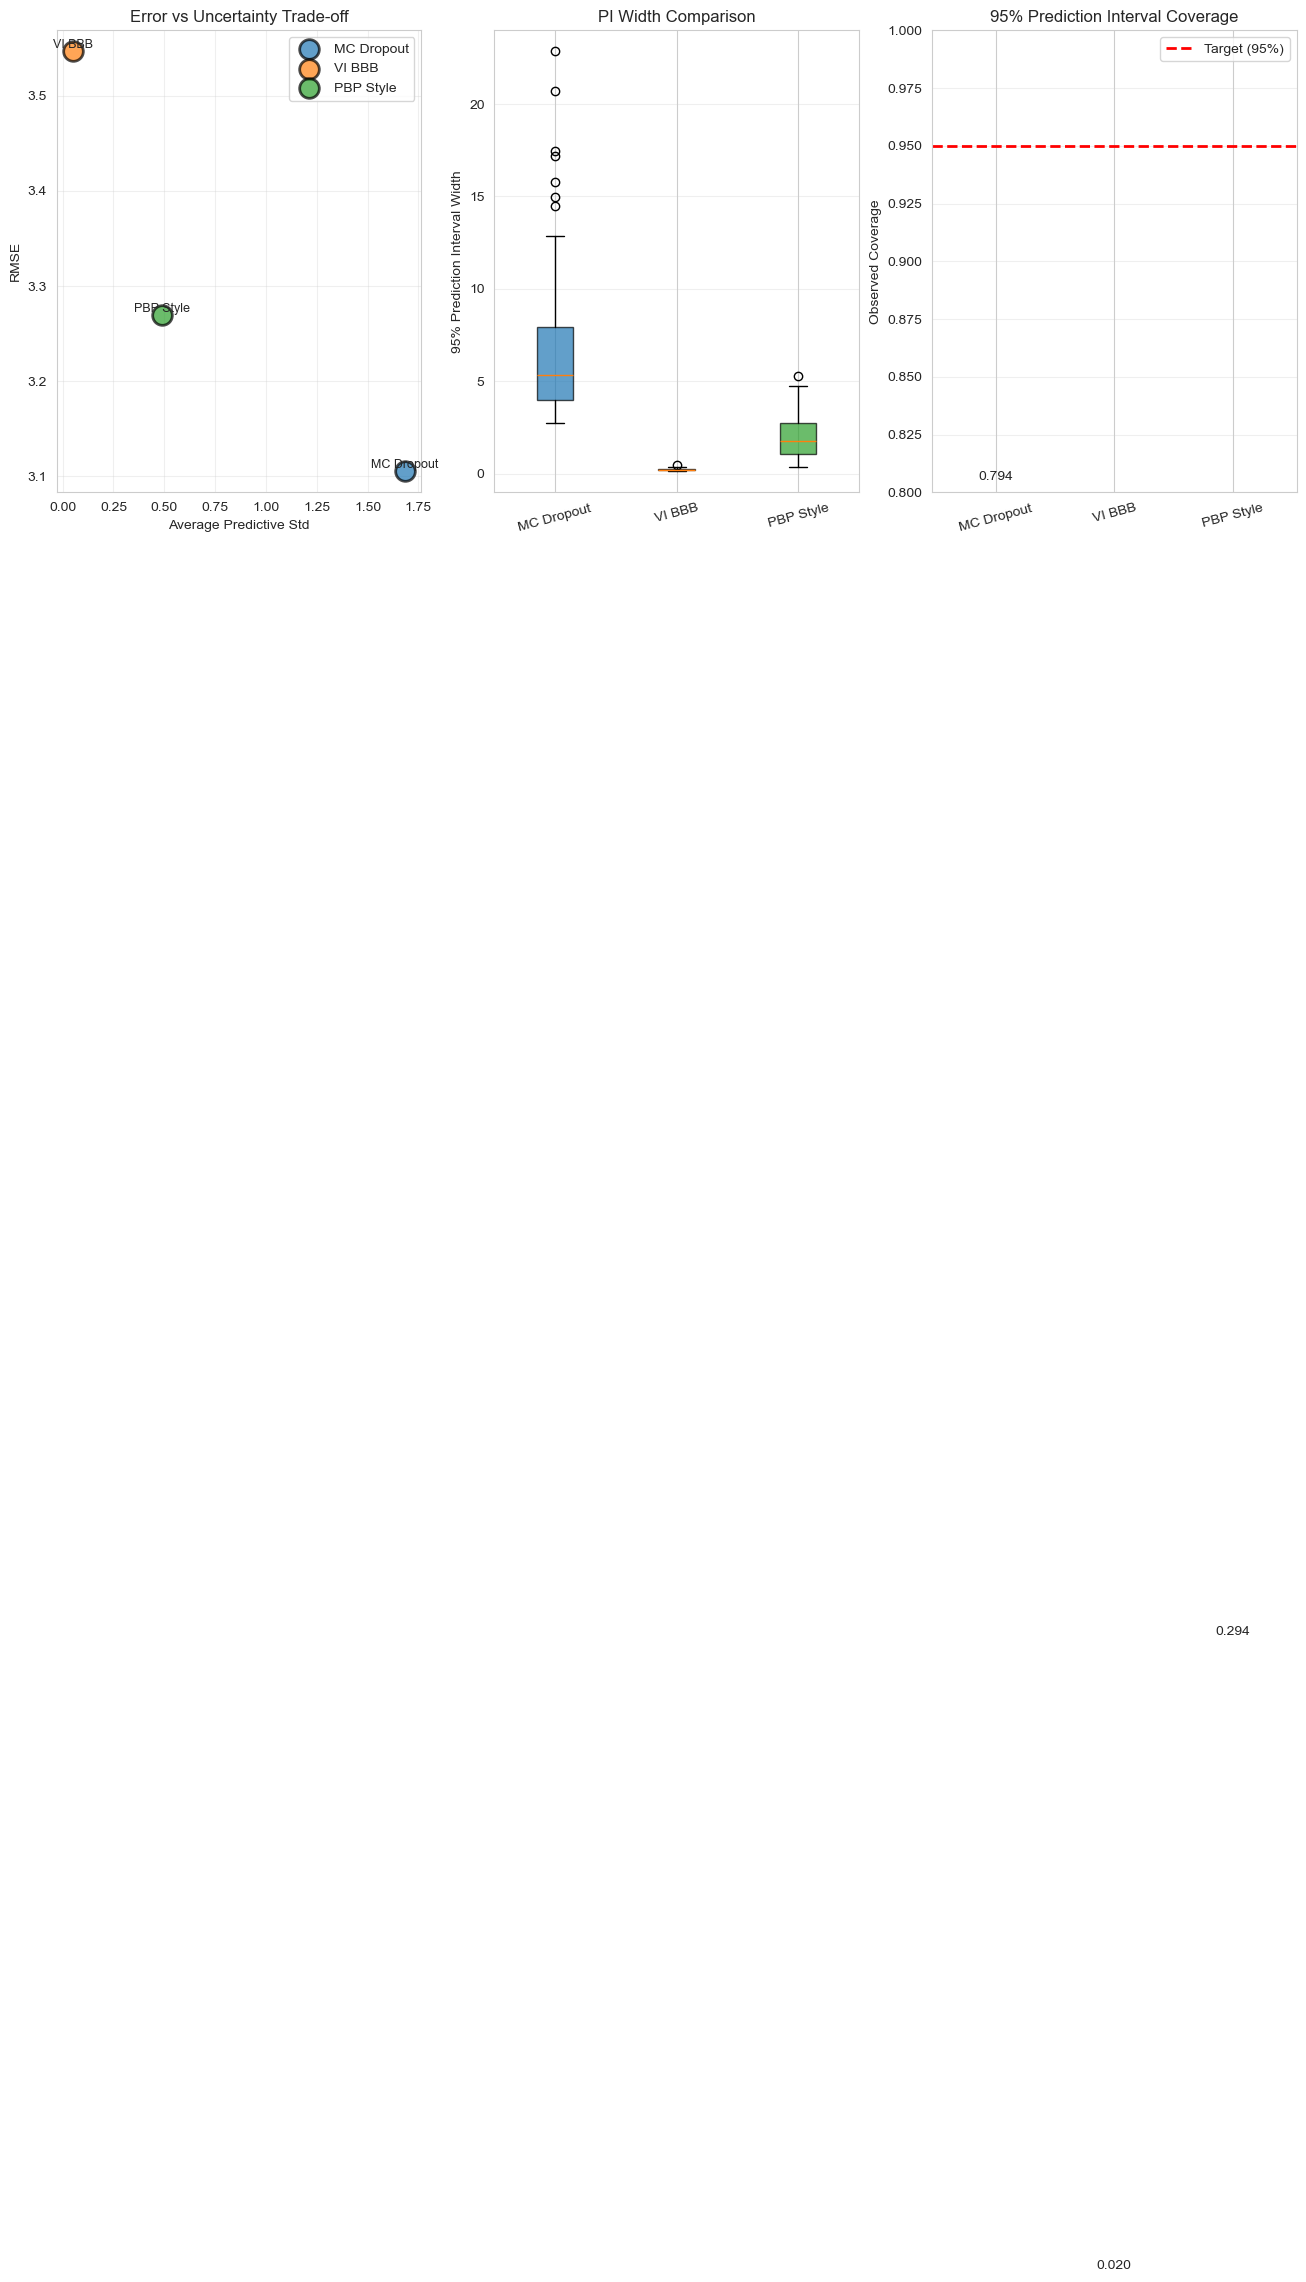


✅ All plots generated successfully!
📊 Saved: mc_dropout_analysis.png and comparison_analysis.png


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load Boston Housing Dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

# Prepare data
X = data.drop('medv', axis=1).values
y = data['medv'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ==================== MC DROPOUT MODEL ====================
def create_mc_dropout_model(input_dim, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train MC Dropout model
print("Training MC Dropout Model...")
mc_model = create_mc_dropout_model(X_train_scaled.shape[1])
mc_model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, 
             validation_split=0.2, verbose=0)

# MC Dropout predictions
def mc_dropout_predict(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred, predictions

mc_mean, mc_std, mc_samples = mc_dropout_predict(mc_model, X_test_scaled)

# Inverse transform predictions
mc_mean_orig = scaler_y.inverse_transform(mc_mean.reshape(-1, 1)).flatten()
mc_std_orig = mc_std * scaler_y.scale_

# ==================== STANDARD MODEL (NO DROPOUT) ====================
def create_standard_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

print("Training Standard Model...")
std_model = create_standard_model(X_train_scaled.shape[1])
std_model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, 
              validation_split=0.2, verbose=0)
std_pred_scaled = std_model.predict(X_test_scaled, verbose=0).flatten()
std_pred = scaler_y.inverse_transform(std_pred_scaled.reshape(-1, 1)).flatten()

# ==================== VARIATIONAL INFERENCE (APPROXIMATION) ====================
class DenseVariational(layers.Layer):
    def __init__(self, units, kl_weight, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.kl_weight = kl_weight
        
    def build(self, input_shape):
        self.w_mu = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='w_mu'
        )
        self.w_rho = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True,
            name='w_rho'
        )
        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='b_mu'
        )
        self.b_rho = self.add_weight(
            shape=(self.units,),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True,
            name='b_rho'
        )
        
    def call(self, inputs, training=None):
        if training:
            w_sigma = tf.nn.softplus(self.w_rho)
            w = self.w_mu + w_sigma * tf.random.normal(self.w_mu.shape)
            b_sigma = tf.nn.softplus(self.b_rho)
            b = self.b_mu + b_sigma * tf.random.normal(self.b_mu.shape)
            
            # KL divergence
            kl = self.kl_weight * (
                tf.reduce_sum(tf.math.log(w_sigma)) + 
                tf.reduce_sum(tf.math.log(b_sigma))
            )
            self.add_loss(kl)
        else:
            w = self.w_mu
            b = self.b_mu
            
        return tf.matmul(inputs, w) + b

def create_vi_model(input_dim, kl_weight=0.001):
    inputs = layers.Input(shape=(input_dim,))
    x = DenseVariational(128, kl_weight)(inputs)
    x = layers.Activation('relu')(x)
    x = DenseVariational(64, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(32, kl_weight)(x)
    x = layers.Activation('relu')(x)
    outputs = DenseVariational(1, kl_weight)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

print("Training Variational Inference Model...")
vi_model = create_vi_model(X_train_scaled.shape[1])
vi_model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32,
             validation_split=0.2, verbose=0)

# VI predictions
def vi_predict(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred, predictions

vi_mean, vi_std, vi_samples = vi_predict(vi_model, X_test_scaled)
vi_mean_orig = scaler_y.inverse_transform(vi_mean.reshape(-1, 1)).flatten()
vi_std_orig = vi_std * scaler_y.scale_

# ==================== PROBABILISTIC BACKPROP (SIMPLIFIED) ====================
# Using ensemble as PBP approximation
def create_pbp_ensemble(input_dim, n_models=5):
    models = []
    for _ in range(n_models):
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=input_dim,
                        kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.Dense(64, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.Dense(32, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        models.append(model)
    return models

print("Training PBP Ensemble...")
pbp_models = create_pbp_ensemble(X_train_scaled.shape[1])
for i, model in enumerate(pbp_models):
    model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32,
              validation_split=0.2, verbose=0)

def pbp_predict(models, X):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred, predictions

pbp_mean, pbp_std, pbp_samples = pbp_predict(pbp_models, X_test_scaled)
pbp_mean_orig = scaler_y.inverse_transform(pbp_mean.reshape(-1, 1)).flatten()
pbp_std_orig = pbp_std * scaler_y.scale_

# ==================== CALCULATE METRICS ====================
def calculate_metrics(y_true, y_pred, std):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Coverage (95% prediction interval)
    lower = y_pred - 1.96 * std
    upper = y_pred + 1.96 * std
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    
    # Negative Log-Likelihood
    nll = -np.mean(stats.norm.logpdf(y_true, loc=y_pred, scale=std + 1e-6))
    
    return {'RMSE': rmse, 'MAE': mae, 'Coverage95': coverage, 'NLL': nll}

mc_metrics = calculate_metrics(y_test, mc_mean_orig, mc_std_orig)
vi_metrics = calculate_metrics(y_test, vi_mean_orig, vi_std_orig)
pbp_metrics = calculate_metrics(y_test, pbp_mean_orig, pbp_std_orig)

print("\n=== Model Performance ===")
print(f"MC Dropout  - RMSE: {mc_metrics['RMSE']:.4f}, MAE: {mc_metrics['MAE']:.4f}, Coverage: {mc_metrics['Coverage95']:.4f}, NLL: {mc_metrics['NLL']:.4f}")
print(f"VI BBB      - RMSE: {vi_metrics['RMSE']:.4f}, MAE: {vi_metrics['MAE']:.4f}, Coverage: {vi_metrics['Coverage95']:.4f}, NLL: {vi_metrics['NLL']:.4f}")
print(f"PBP Style   - RMSE: {pbp_metrics['RMSE']:.4f}, MAE: {pbp_metrics['MAE']:.4f}, Coverage: {pbp_metrics['Coverage95']:.4f}, NLL: {pbp_metrics['NLL']:.4f}")

# ==================== PLOTTING ====================

# 1. MC DROPOUT PLOTS
fig = plt.figure(figsize=(16, 12))

# 1.1 True vs Predicted Scatter Plot
plt.subplot(3, 3, 1)
plt.scatter(y_test, mc_mean_orig, alpha=0.6, c=mc_std_orig, cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.colorbar(label='Uncertainty (Std)')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('MC Dropout: True vs Predicted')
plt.grid(True, alpha=0.3)

# 1.2 Residuals Plot
plt.subplot(3, 3, 2)
residuals = y_test - mc_mean_orig
plt.scatter(y_test, residuals, alpha=0.6, c=mc_std_orig, cmap='viridis')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.colorbar(label='Uncertainty (Std)')
plt.xlabel('Target Value')
plt.ylabel('Residuals')
plt.title('MC Dropout: Residuals Plot')
plt.grid(True, alpha=0.3)

# 1.3 Prediction Interval Plot
plt.subplot(3, 3, 3)
sorted_idx = np.argsort(y_test)
sorted_test = y_test[sorted_idx]
sorted_pred = mc_mean_orig[sorted_idx]
sorted_std = mc_std_orig[sorted_idx]
x_range = np.arange(len(sorted_test))

plt.plot(x_range, sorted_test, 'b-', label='True', alpha=0.7, linewidth=2)
plt.plot(x_range, sorted_pred, 'r-', label='Predicted', alpha=0.7, linewidth=2)
plt.fill_between(x_range, 
                 sorted_pred - 1.96*sorted_std, 
                 sorted_pred + 1.96*sorted_std, 
                 alpha=0.3, color='red', label='95% PI')
plt.xlabel('Sample Index (sorted by true value)')
plt.ylabel('Value')
plt.title('MC Dropout: Prediction Interval')
plt.legend()
plt.grid(True, alpha=0.3)

# 1.4 Uncertainty vs Prediction Error
plt.subplot(3, 3, 4)
abs_errors = np.abs(y_test - mc_mean_orig)
plt.scatter(mc_std_orig, abs_errors, alpha=0.6)
z = np.polyfit(mc_std_orig, abs_errors, 1)
p = np.poly1d(z)
plt.plot(mc_std_orig, p(mc_std_orig), "r--", lw=2, label=f'Trend (corr={np.corrcoef(mc_std_orig, abs_errors)[0,1]:.3f})')
plt.xlabel('Predictive Uncertainty (Std)')
plt.ylabel('Absolute Error')
plt.title('MC Dropout: Uncertainty vs Error')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. STANDARD vs MC DROPOUT COMPARISON
# 2.1 Prediction Interval Overlay
plt.subplot(3, 3, 5)
sorted_idx = np.argsort(y_test)
x_range = np.arange(len(sorted_test))
plt.plot(x_range, sorted_test, 'b-', label='True', alpha=0.7, linewidth=2)
plt.plot(x_range, std_pred[sorted_idx], 'g-', label='Standard Model', alpha=0.7, linewidth=2)
plt.plot(x_range, sorted_pred, 'r-', label='MC Dropout', alpha=0.7, linewidth=2)
plt.fill_between(x_range, 
                 sorted_pred - 1.96*sorted_std, 
                 sorted_pred + 1.96*sorted_std, 
                 alpha=0.2, color='red', label='MC 95% PI')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Standard vs MC Dropout')
plt.legend()
plt.grid(True, alpha=0.3)

# 2.2 Uncertainty Distribution
plt.subplot(3, 3, 6)
plt.hist(mc_std_orig, bins=30, alpha=0.7, label='MC Dropout', density=True)
plt.axvline(mc_std_orig.mean(), color='red', linestyle='--', 
            label=f'Mean={mc_std_orig.mean():.2f}')
plt.xlabel('Predictive Uncertainty (Std)')
plt.ylabel('Density')
plt.title('MC Dropout: Uncertainty Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 2.3 Calibration Plot
plt.subplot(3, 3, 7)
confidence_levels = np.linspace(0.1, 0.99, 20)
observed_coverage = []
for conf in confidence_levels:
    z_score = stats.norm.ppf((1 + conf) / 2)
    lower = mc_mean_orig - z_score * mc_std_orig
    upper = mc_mean_orig + z_score * mc_std_orig
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    observed_coverage.append(coverage)

plt.plot(confidence_levels, confidence_levels, 'r--', label='Perfect Calibration', lw=2)
plt.plot(confidence_levels, observed_coverage, 'b-o', label='MC Dropout', markersize=4)
plt.xlabel('Expected Coverage')
plt.ylabel('Observed Coverage')
plt.title('Calibration Plot for Regression')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. MC vs VI vs PBP COMPARISON
# 3.1 Predictive Variance KDE
plt.subplot(3, 3, 8)
from scipy.stats import gaussian_kde
mc_variance = mc_std_orig ** 2
vi_variance = vi_std_orig ** 2
pbp_variance = pbp_std_orig ** 2

kde_mc = gaussian_kde(mc_variance)
kde_vi = gaussian_kde(vi_variance)
kde_pbp = gaussian_kde(pbp_variance)
x_grid = np.linspace(0, max(mc_variance.max(), vi_variance.max(), pbp_variance.max()), 200)

plt.plot(x_grid, kde_mc(x_grid), label='MC Dropout', linewidth=2)
plt.plot(x_grid, kde_vi(x_grid), label='VI BBB', linewidth=2)
plt.plot(x_grid, kde_pbp(x_grid), label='PBP Style', linewidth=2)
plt.xlabel('Predictive Variance')
plt.ylabel('Density')
plt.title('Predictive Variance Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 3.2 NLL Bar Chart
plt.subplot(3, 3, 9)
methods = ['MC Dropout', 'VI BBB', 'PBP Style']
nlls = [mc_metrics['NLL'], vi_metrics['NLL'], pbp_metrics['NLL']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = plt.bar(methods, nlls, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Negative Log-Likelihood')
plt.title('NLL Comparison')
plt.xticks(rotation=15)
for bar, nll in zip(bars, nlls):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{nll:.2f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('mc_dropout_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Second figure for additional comparisons
fig2 = plt.figure(figsize=(16, 6))

# 3.3 Error vs Uncertainty Trade-off
plt.subplot(1, 3, 1)
rmse_values = [mc_metrics['RMSE'], vi_metrics['RMSE'], pbp_metrics['RMSE']]
avg_std = [mc_std_orig.mean(), vi_std_orig.mean(), pbp_std_orig.mean()]

for i, (method, color) in enumerate(zip(methods, colors)):
    plt.scatter(avg_std[i], rmse_values[i], s=200, c=color, alpha=0.7, 
                edgecolors='black', linewidth=2, label=method)
    plt.text(avg_std[i], rmse_values[i], method, fontsize=9, 
             ha='center', va='bottom')

plt.xlabel('Average Predictive Std')
plt.ylabel('RMSE')
plt.title('Error vs Uncertainty Trade-off')
plt.legend()
plt.grid(True, alpha=0.3)

# 3.4 Prediction Interval Width Comparison
plt.subplot(1, 3, 2)
mc_width = 2 * 1.96 * mc_std_orig
vi_width = 2 * 1.96 * vi_std_orig
pbp_width = 2 * 1.96 * pbp_std_orig

bp = plt.boxplot([mc_width, vi_width, pbp_width], 
                  labels=methods, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.ylabel('95% Prediction Interval Width')
plt.title('PI Width Comparison')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')

# 3.5 Coverage Comparison
plt.subplot(1, 3, 3)
coverages = [mc_metrics['Coverage95'], vi_metrics['Coverage95'], pbp_metrics['Coverage95']]
bars = plt.bar(methods, coverages, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=0.95, color='r', linestyle='--', lw=2, label='Target (95%)')
plt.ylabel('Observed Coverage')
plt.title('95% Prediction Interval Coverage')
plt.xticks(rotation=15)
plt.ylim([0.8, 1.0])
for bar, cov in zip(bars, coverages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{cov:.3f}', ha='center', va='bottom')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All plots generated successfully!")
print("📊 Saved: mc_dropout_analysis.png and comparison_analysis.png")